# Загрузка таблиц #

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
path_1 = './np_database_1.csv'
path_2 = './np_database_2.csv'

In [25]:
data1 = pd.read_csv(path_1)
data2 = pd.read_csv(path_2)


# Преобразование в единую БД #


Nanoparticle - Material

Type: Organic (O)/inorganic (I) - Type

coat - Coat

Diameter (nm) - Diameter (nm)

Concentration μM  - Concentration (ug/ml)


Cells - Cell_Type

Cell line (L)/primary cells (P) - Cell Line_Primary Cell

Human(H)/Animal(A) cells - Human_Animal

Cell age: embryonic (E), Adult (A) - Cell_Age

Exposure time (h) - Time (hr)

% Cell viability - Cell_Viability (%)

Zeta potential (mV) - Surface_Charge


## Преобразуем Zeta potential (mV) в номинативные значения ##

In [26]:
data1['Zeta potential (mV)'] = data1['Zeta potential (mV)']. fillna (0) # заполняем пропуски нулями
data1["Zeta potential (mV)"] = data1['Zeta potential (mV)'].astype('float64') # приводим к типу float


In [ ]:
for i in range(len(data1['Zeta potential (mV)'])): # заменяем значения из стобца на номинативные(Positive,Negative,unknown)
  if data1['Zeta potential (mV)'][i] < 0:
    data1['Zeta potential (mV)'][i] = 'Negative'
  elif data1['Zeta potential (mV)'][i] > 0:
    data1['Zeta potential (mV)'][i] = 'Positive'
  else:
    data1['Zeta potential (mV)'][i] = 'unknown'

## Очистка данных и заполнение пропусков ##

In [28]:
# переименовываем первую таблицу для последующего соединения со второй таблицей
data1.rename(columns = {'Nanoparticle':'Material',
                        'Type: Organic (O)/inorganic (I)':'Type',
                        'coat':'Coat',
                        'Concentration μM':'Concentration (ug/ml)',
                        'Cells':'Cell_Type',
                        'Cell line (L)/primary cells (P)': 'Cell Line_Primary Cell',
                        'Human(H)/Animal(A) cells': 'Human_Animal',
                        'Cell age: embryonic (E), Adult (A)': 'Cell_Age',
                        'Exposure time (h)': 'Time (hr)',
                        '% Cell viability': 'Cell_Viability (%)',
                        'Zeta potential (mV)':'Surface_Charge'}, inplace = True )

In [29]:
duplicateRows = data2[data2.duplicated (keep='last')] # удаляем дубликаты(их нет)
data2 = data2.drop_duplicates()

In [30]:
# удаляем ненужные столбцы, и столбцы неподдающиеся соединению
data2 = data2.drop(columns=['No','Year','DOI'])
data1 = data1.drop(columns='Unnamed: 0')
data2 = data2.drop(columns='Unnamed: 0')

In [31]:
data2 = data2[data2.Surface_Charge != '-'] # удаляем 1 строку с ошибкой

Заполняем пропуски

In [32]:
data1['Coat'] = data1['Coat'].fillna('None') # заменяем пропуски в Coat на None

# Заполняем пропуски в столбце Diametr средним значением столбца и приводим к типпу float64
data2.loc[(data2['Diameter (nm)'] =='-'),'Diameter (nm)'] = data2[data2['Diameter (nm)']!='-']['Diameter (nm)'].astype('float64').mean()
data2['Diameter (nm)'] = data2['Diameter (nm)'].astype('float64')

# Заполняем пропуски в столбце Concentration (ug/ml) средним значением столбца и приводим к типпу float64
data2.loc[(data2['Concentration (ug/ml)'] =='-'),'Concentration (ug/ml)'] = data2[data2['Concentration (ug/ml)']!='-']['Concentration (ug/ml)'].astype('float64').mean()
data2['Concentration (ug/ml)'] = data2['Concentration (ug/ml)'].astype('float64')


Заменяем значения

In [33]:
# во второй таблице в Material приводим значения к одному Iron oxide
data2.loc[(data2.Material =='IronOide'),'Material'] = 'Iron oxide'
data2.loc[(data2.Material =='IronOxide'),'Material'] = 'Iron oxide'

# заменяем в столбце Cell_Age значения на A, E
data2.loc[(data2.Cell_Age =='Adult'), 'Cell_Age' ]= 'A'
data2.loc[(data2.Cell_Age =='Embryonic'),'Cell_Age'] = 'E'

# приводим числовые данные к типу float64
data2['Cell_Viability (%)'] = data2['Cell_Viability (%)'].astype('float64')
data1['Cell_Viability (%)'] = data1['Cell_Viability (%)'].astype('float64')


В первой таблице нужно привести столбец Concentration (ug/ml) к единице измерения ug/ml (сейчас она в μM) путем деления на 1000 и умножения на молярную массу вещества

In [34]:
data1.loc[(data1['Material'] =='Iron oxide'),'Concentration (ug/ml)'] = data1.loc[(data1['Material'] =='Iron oxide'),'Concentration (ug/ml)'] /1000 * 159.69
data1.loc[(data1['Material'] =='Au'),'Concentration (ug/ml)'] = data1.loc[(data1['Material'] =='Au'),'Concentration (ug/ml)'] /1000 * 196.96
data1.loc[(data1  ['Material'] =='CuO'),'Concentration (ug/ml)'] = data1.loc[(data1['Material'] =='CuO'),'Concentration (ug/ml)'] /1000 * 79.54


0<= Cell_Viability (%) <= 100

In [35]:
# удалям строки с Cell_Viability (%) < 0 or > 100 (Очевидно)
data1 = data1[(data1['Cell_Viability (%)']>=0) & (data1['Cell_Viability (%)']<=100)]
data2 = data2[(data2['Cell_Viability (%)']>=0) & (data2['Cell_Viability (%)']<=100)]

Дополнительные преобразования

In [ ]:
# # Логорифмируем некоторые показатели, для получения лучшей зависимости и уменьшению выбросов
# concentration1 = [np.log(c) for c in data1['Concentration (ug/ml)']]
# data1['Concentration (ug/ml)'] = concentration1

# concentration2 = [np.log(c) for c in data2['Concentration (ug/ml)']]
# data2['Concentration (ug/ml)'] = concentration2

# viability1 = [np.log(p) for p in data1['Cell_Viability (%)']]
# data1['Cell_Viability (%)'] = viability1

# viability2 = [np.log(p) for p in data2['Cell_Viability (%)']]
# data2['Cell_Viability (%)'] = viability2

## Соединяем всё в одну БД ##

In [36]:
data = pd.concat([data1, data2], ignore_index=True)
data

,Material,Type,Coat,Diameter (nm),Concentration (ug/ml),Surface_Charge,Cell_Type,Cell Line_Primary Cell,Human_Animal,Cell_Age,Time (hr),Cell_Viability (%)
0,CuO,I,None,52.51,0.000003,Negative,A549,L,H,A,24,74.587160
1,CuO,I,None,52.51,0.000007,Negative,A549,L,H,A,24,66.055046
2,CuO,I,None,52.51,0.000014,Negative,A549,L,H,A,24,48.165140
3,CuO,I,None,52.51,0.000003,Negative,A549,L,H,A,24,84.713870
4,CuO,I,None,52.51,0.000007,Negative,A549,L,H,A,24,68.672810
...,...,...,...,...,...,...,...,...,...,...,...,...
1525,Au,I,Citrate,4.70,100.000000,Negative,RAW264.7,L,A,A,48,68.957000
1526,Au,I,Citrate,270.00,5.000000,Negative,RAW264.7,L,A,A,48,93.893000
1527,Au,I,Citrate,270.00,10.000000,Negative,RAW264.7,L,A,A,48,86.005000
1528,Au,I,Citrate,270.00,100.000000,Negative,RAW264.7,L,A,A,48,79.644000


# Анализ Данных #


## Работаем с выбросами ##

С выбросами

In [37]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y=data['Concentration (ug/ml)'], name='Concentration (ug/ml)'))

fig.show()

fig2 = go.Figure()
fig2.add_trace(go.Box(y=data['Time (hr)'], name='Time (hr)'),)
fig2.add_trace(go.Box(y=data['Diameter (nm)'], name='Diameter (nm)'))

fig2.show()

fig3 = go.Figure()
fig3.add_trace(go.Box(y=data['Cell_Viability (%)'], name='Cell_Viability (%)'),)

fig3.show()

In [38]:
data_clean = data.copy()
n_name = ['Concentration (ug/ml)','Diameter (nm)','Time (hr)','Cell_Viability (%)']
for i in n_name:
  Q1 = data[i].quantile(q=.25)
  Q3 = data[i].quantile(q=.75)
  IQR = Q3-Q1
  mult = 1.5
  data_clean = data_clean[~((data_clean[i] < (Q1-1.5*IQR)) | (data_clean[i] > (Q3+1.5*IQR)))]

In [39]:
data_clean.to_csv('minitask_1_13.csv')

После работы с выбросами методом iqr

In [21]:
fig4 = go.Figure()
fig4.add_trace(go.Box(y=data_clean['Concentration (ug/ml)'], name='Concentration (ug/ml)'))

fig4.show()

fig5 = go.Figure()
fig5.add_trace(go.Box(y=data_clean['Time (hr)'], name='Time (hr)'),)
fig5.add_trace(go.Box(y=data_clean['Diameter (nm)'], name='Diameter (nm)'))

fig5.show()

fig6 = go.Figure()
fig6.add_trace(go.Box(y=data_clean['Cell_Viability (%)'], name='Cell_Viability (%)'),)

fig6.show()

## Кодирование категориальных признаков ##

In [40]:
df = data_clean.copy()

In [41]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dicts = {}

label.fit(df.Coat.drop_duplicates())
dicts['Coat'] = list(label.classes_)
df['Coat'] = label.transform(df['Coat'])

label.fit(df.Surface_Charge.drop_duplicates())
dicts['Surface_Charge'] = list(label.classes_)
df['Surface_Charge'] = label.transform(df['Surface_Charge'])

label.fit(df.Cell_Type.drop_duplicates())
dicts['Cell_Type'] = list(label.classes_)
df['Cell_Type'] = label.transform(df['Cell_Type'])

label.fit(df['Cell Line_Primary Cell'].drop_duplicates())
dicts['Cell Line_Primary Cell'] = list(label.classes_)
df['Cell Line_Primary Cell'] = label.transform(df['Cell Line_Primary Cell'])

label.fit(df.Human_Animal.drop_duplicates())
dicts['Human_Animal'] = list(label.classes_)
df['Human_Animal'] = label.transform(df['Human_Animal'])

label.fit(df.Cell_Age.drop_duplicates())
dicts['Cell_Age'] = list(label.classes_)
df['Cell_Age'] = label.transform(df['Cell_Age'])


## HeatMap ##


In [42]:
import plotly.express as px

fig = px.imshow(df.corr(), text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.BuPu)
fig.show()

<ipython-input-42-8b690c044d55>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## Распределения числовых выборок ##


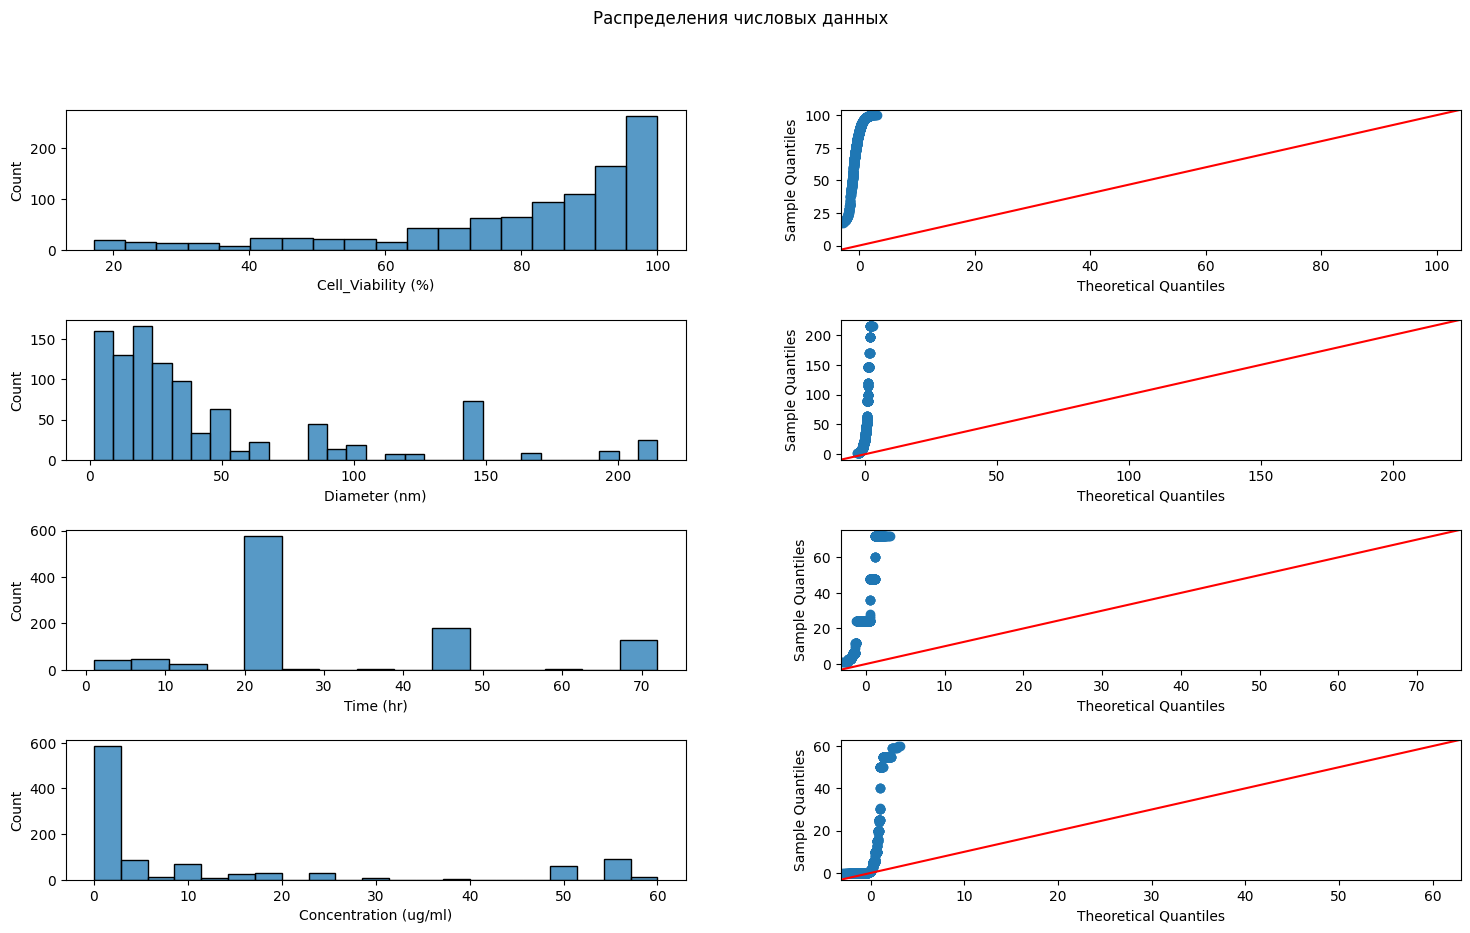

In [46]:
import statsmodels.api as sm
import seaborn as sns

fig, axes = plt.subplots(4, 2, figsize=(18, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.5)

fig.suptitle('Распределения числовых данных')

numeric_cols = ['Cell_Viability (%)', 'Diameter (nm)', 'Time (hr)', 'Concentration (ug/ml)']
for i, col in enumerate(numeric_cols):
  sns.histplot(ax=axes[i, 0], data=data_clean[col])
  sm.qqplot(ax=axes[i, 1], data=data_clean[col], line='45')


## Качественные признаки ##

In [47]:
import plotly.graph_objects as go

fig8 = px.histogram(data_clean, x='Material',
             title="Count of Materials",
                   color = 'Material',
                   color_discrete_sequence=[
                        px.colors.qualitative.Alphabet[11],
                        px.colors.qualitative.Plotly[2],
                        px.colors.qualitative.Plotly[7],
                        px.colors.qualitative.G10[5]]
             )

fig8.show()

In [49]:
res = []
for j in list(data_clean.Material.unique()):
  res.append(pd.Series([i for i in data_clean[data_clean.Material==j]['Cell_Viability (%)']]).mean())

fig9 = go.Figure()
fig9.add_trace(go.Bar(
    y=res,
    x=list(data_clean.Material.unique(),

    ),

))

fig9.update_layout(
    title='Average Cell_Viability for Material',
    yaxis_title='average Cell_Viability (%)',
    xaxis_title='Material',
)

fig9.update_yaxes(
    range=[60,100]
)
fig9.show()

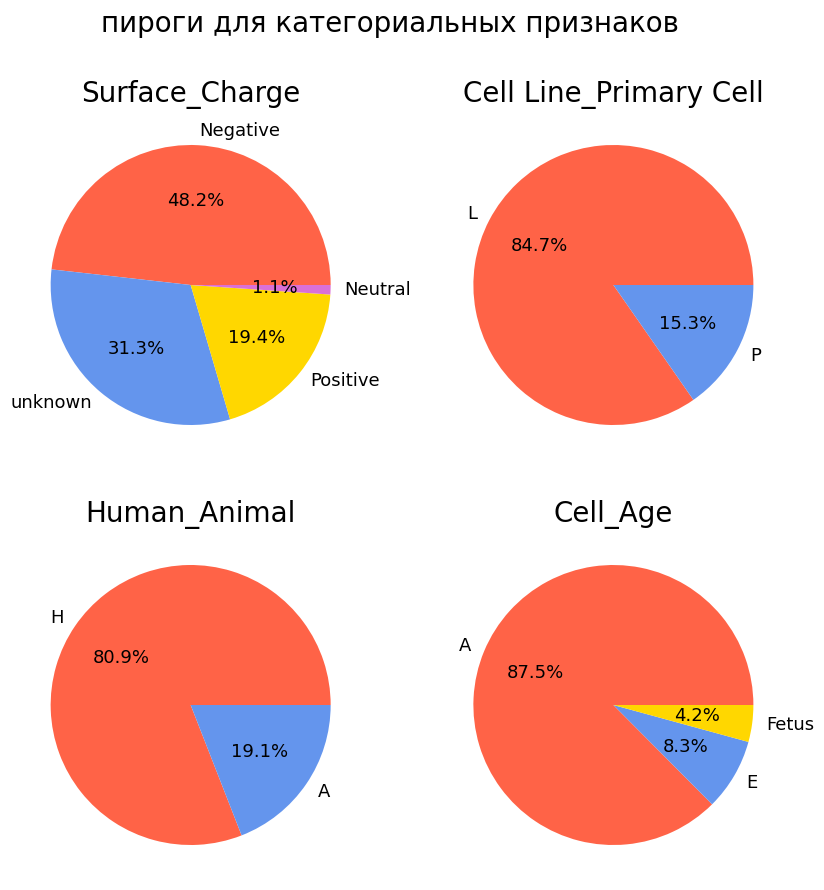

In [50]:
cat_cols = ['Surface_Charge', 'Cell Line_Primary Cell', 'Human_Animal',	'Cell_Age']
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('пироги для категориальных признаков', fontsize=20)
ax = ax.flatten()
for i, col in enumerate(cat_cols):
    ax[i].pie(data_clean[col].value_counts(), textprops={'fontsize': 13}, labels=data_clean[col].unique(), autopct='%1.1f%%', colors=[
                                                                    'tomato', 'cornflowerblue',
                                                                    'gold', 'orchid', 'green'])
    ax[i].set_title(col, fontsize = 20)